## Get the data about rent in Ukraine

I will focus on 3 biggest rental websites in Ukraine:
- OLX
- Dom.ria
- Lun

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 1000)


<p style="max-width:75ch;text-align:justify;">I've gathered the data into 4 different csvs, that I will provide in the repo. It's worth explaining them</p>

- `olx_no_pets.csv` - contains data about all not pet-friendly listings on olx
- `olx_yes_pets.csv` - contains data about all pet-friendly listings on olx
- `dim_ria.csv` - contaies data about all listings on dim.ria from all cities
- `lun.csv` - contains data about all listings on lun from all cities

<p style="max-width:75ch;text-align:justify;">
These datasets, though contain all the necessary information, are <b>HUGELY</b> (and I mean it) disorganized.
For now I'll set a simple goal of just standartizing the data in each csv separately (SMASH olx together!), and then I'll combine then for further exploratory analysis and exportation to SQL
</p>


## Cleaning the data

<p style='text-align:justify;max-width:75ch;'>
I would first - separate and extract as much data as possible, into as many new categorical columns as possible. Even if I would create more categorical columns for one listing website then for the other two.
</p>

In [140]:
olx_pets_no = pd.read_csv("olx_no_pets.csv")
olx_pets_yes = pd.read_csv("olx_yes_pets.csv")
dim_ria = pd.read_csv("dim_ria.csv")
lun = pd.read_csv("lun.csv")

### OLX

<p style="max-width:75ch;text-align:justify;">
I already know that olx would be the hardest to do(olx-people, not me &#128064;).</br>
Let me explain why (no, I'm not crying). I'm not that advanced in data scrapping, and I don't think anyone is, to the extent to figure out each specific page link for a listing, because olx doesn't follow some link-id pattern (I guess nobody from my rental website sample does).
</p>

That's why there are only 2 options:
1. Just don't touch olx
2. Extranct the data from the main 'list' page

<p style="max-width:75ch;text-align:justify;">
Because more data = more fun, I went with the 2nd option. There is a caveat of course, olx is not a renting website, so there are no designated fields for number of rooms,  pet-allowance, etc. You could filter for all of that (what I partially did), but adding more than 1 fillter (splitting your dataset in half), would be hard to combine all the data together, and I don't want that (I'm also just not interested in anything except pet-allowance &#128519;). That's why I have 2 datasets.
</p>


In [141]:
print("OLX no pets allowed: \n", olx_pets_no.head())
print("OLX pets allowed: \n", olx_pets_yes.head())
print(olx_pets_no.info())
print(olx_pets_yes.info())

OLX no pets allowed: 
    page        price                                                url                               location                                              title                                               size origin pets
0     1   8 800 грн.  https://www.olx.ua/uk/nedvizhimost/kvartiry/do...   Харьков, Салтовский - 30 мая 2025 г.  Сдам свою 2х. Ком. Новострой Гв. Широнинцев (С...  .css-156kzg6{height:16px;width:16px;margin-rig...    olx   no
1     1   9 553 грн.  https://www.olx.ua/uk/nedvizhimost/kvartiry/do...              Черновцы - 30 мая 2025 г.  Здам 1 кімнатну, ЩЕРБАНЮКА (ПАРК ШЕВЧЕНКА) є з...                                              33 м²    olx   no
2     1  15 000 грн.  https://www.olx.ua/uk/nedvizhimost/kvartiry/do...  Киев, Шевченковский - Сегодня в 06:51  Оренда 1 кімн. квартири вул. Казарменна (Андрю...                                              33 м²    olx   no
3     1  35 000 грн.  https://www.olx.ua/uk/nedvizhimost/kvartiry/do...  Киев

#### From looking at the dataset, I have a few things I want to do:
1. Find if there are listings that are in both datasets and merge them
2. Remove some strange .css from any column
3. Convert size to float
4. Remove any sort of time from location
5. Split location column into City and District

In [142]:
intersect = olx_pets_no.merge(
    olx_pets_yes,
    how="inner",
    on=["title", "price", "location", "size"],
    suffixes=("_no", "_yes"),
)
print("Number of indecisive owners:", intersect.shape[0])

Number of indecisive owners: 6


##### So 6 indecivise owners. I'll change thier pet allowance status to 'Both'. I'll use the intersect as a filter

In [143]:
# Set ingex to be title, price, location, size
intersect_mask = (
    intersect[["title", "price", "location", "size"]]
    .set_index(["title", "price", "location", "size"])
    .index
)
# Create a filter for olx_pets_no by the intersect_mask
mask_pets_no = olx_pets_no.set_index(["title", "price", "location", "size"]).index.isin(
    intersect_mask
)
# Filter olx_pets_no using the mask and set the 'pets' column to 'Both'
olx_pets_no.loc[mask_pets_no,'pets']= 'Both'

# Check the result
olx_pets_no[mask_pets_no]

page        price                                                url                                   location                                              title   size origin  pets
403     8   8 000 грн.  https://www.olx.ua/uk/nedvizhimost/kvartiry/do...                  Луцьк - 30 травня 2025 р.        Здам в довгострокову оренду житло. Власник.  60 м²    olx  Both
473    10   5 000 грн.  https://www.olx.ua/uk/nedvizhimost/kvartiry/do...              Коростень - 30 травня 2025 р.  Здається однокімнатна квартира з усіма зручнос...  38 м²    olx  Both
516    11  30 000 грн.  https://www.olx.ua/uk/nedvizhimost/kvartiry/do...     Дніпро, Центральний - Сьогодні о 15:59        Сдам квартиру Центр, Новострой. ПЕРША ЗДАЧА  40 м²    olx  Both
518    11  10 000 грн.  https://www.olx.ua/uk/nedvizhimost/kvartiry/do...  Дніпро, Шевченківський - Сьогодні о 11:50  Сдам 1 к студию с ремонтом р-н низ Рабочей / п...  28 м²    olx  Both
834    17   5 999 грн.  https://www.olx.ua/uk/nedvizhimost/kvartiry/do...            Коцюбинське - 27 травня 2025 р.  Аренда 1к квартири Коцюбинське ТЦ Лавина Акаде...  30 м²    olx  Both
872    17  12 000 грн.  https://www.olx.ua/uk/nedvizhimost/kvartiry/do...        Івано-Франківськ - Сьогодні о 10:29                     3к особняк з подвір'ям р-н Бам  55 м²    olx  Both

In [144]:
# Do the same for olx_pets_yes
mask_pets_yes = olx_pets_yes.set_index(
    ["title", "price", "location", "size"]
).index.isin(intersect_mask)

olx_pets_yes.loc[mask_pets_yes, "pets"] = "Both"

##### Now I'll remove the duplicates from the df, to make my laptops live a bit easier

In [145]:
# Smash the two dataframes together
olx_full = pd.concat([olx_pets_no, olx_pets_yes], ignore_index=True)
olx_full.drop(columns=['page','url'], inplace=True)
# Find the duplicates based on the only columns that matter
print("Number of duplicates",olx_full.duplicated(subset=["title","location", "size"],keep=False).sum())

# Remove duplicates based on these columns
olx_full=olx_full.drop_duplicates(subset=["title", "location", "size"], keep="first")

# Check the result
print("Number of duplicates after the drop: ",olx_full.duplicated(subset=["title","location", "size"],keep=False).sum())

Number of duplicates 513
Number of duplicates after the drop:  0


##### Now it's time to remove .css from any column (I spotted it only in price and size)

In [146]:
def cleanse_data(df: pd.DataFrame):
    df_mask = (
        df["price"].str.contains("css", na=False)
        | df["size"].str.contains("css", na=False)
        | df["location"].str.contains("css", na=False)
        | df["title"].str.contains("css", na=False)
    )
    df.loc[df_mask, "price"] = df.loc[df_mask, "price"].str.replace(
        r"\.css.*", "", regex=True
    )
    df.loc[df_mask, "size"] = df.loc[df_mask, "size"].str.replace(
        r".*\}", "", regex=True
    )
    return df

In [147]:
cleanse_data(olx_full).head()

price                               location                                              title   size origin pets
0   8 800 грн.   Харьков, Салтовский - 30 мая 2025 г.  Сдам свою 2х. Ком. Новострой Гв. Широнинцев (С...  49 м²    olx   no
1   9 553 грн.              Черновцы - 30 мая 2025 г.  Здам 1 кімнатну, ЩЕРБАНЮКА (ПАРК ШЕВЧЕНКА) є з...  33 м²    olx   no
2  15 000 грн.  Киев, Шевченковский - Сегодня в 06:51  Оренда 1 кімн. квартири вул. Казарменна (Андрю...  33 м²    olx   no
3  35 000 грн.  Киев, Шевченковский - Сегодня в 07:28                     Евро двушка з гарним ремонтом!  50 м²    olx   no
4  17 500 грн.   Одесса, Приморский - Сегодня в 14:07                   Сдам долгосрочно СВОЮ евродвушку  70 м²    olx   no

##### Converting size to float

In [148]:
olx_full['size'] = olx_full['size'].str.replace('м²', '').astype(float)

##### Remove time from location

In [149]:
before_dash_regex = r"\s-\s.*"
olx_full['location']= olx_full['location'].str.replace(
    before_dash_regex, "", regex=True
)
olx_full.head()

price             location                                              title  size origin pets
0   8 800 грн.  Харьков, Салтовский  Сдам свою 2х. Ком. Новострой Гв. Широнинцев (С...  49.0    olx   no
1   9 553 грн.             Черновцы  Здам 1 кімнатну, ЩЕРБАНЮКА (ПАРК ШЕВЧЕНКА) є з...  33.0    olx   no
2  15 000 грн.  Киев, Шевченковский  Оренда 1 кімн. квартири вул. Казарменна (Андрю...  33.0    olx   no
3  35 000 грн.  Киев, Шевченковский                     Евро двушка з гарним ремонтом!  50.0    olx   no
4  17 500 грн.   Одесса, Приморский                   Сдам долгосрочно СВОЮ евродвушку  70.0    olx   no

#### Data Extraction

<p style="max-width:75ch;">Now it's time to extract some data from the title and location. <br> In the title I'll look specificaly for number of rooms, and try creating a list of patterns. I will also split location into city and district.
</p>

##### Rooms

In [150]:
import re

room_patters = [
        # "2-кімнатна", "3 ком", etc.
        r"(\d+)[-\s]*(?:кімнат|ком|кім|комн|комнатная|кімнатна|комнат|х-кв.|х-кімн|х-комн|х-ком|х-кім|х-комн|х-кімнат|х-кімнатна|х-кімнатна|х-кімн.)",  
        r"(?:кімнат|ком|кім|комн|комнатная|кімнатна|комнат|)*(\d+)[-\s]",  
        r"(\d+)[-\s]*к[.,\s]",
        r"(\d+)[-\s]*bedroom",
        r"(\d+)[-\s]*br",
]

def extract_room_count(title,patterns=room_patters):
    
    for pattern in patterns:
        match = re.search(pattern, str(title).lower())
        if match:
            return int(match.group(1))
    return None

olx_full_copy = olx_full.copy()
olx_full_copy["room_count"] = olx_full_copy["title"].apply(extract_room_count)

print("Extraction success rate:",olx_full_copy["room_count"].notna().mean())
print(olx_full_copy.sort_values(by="room_count",ascending=False).head(10))

Extraction success rate: 0.6816999132697311
            price               location                                              title   size origin pets  room_count
1167  30 000 грн.      Київ, Подільський            Оренда квартири ЖК Файна Таун 30000 грн   42.0    olx   no     30000.0
1753  28 000 грн.   Київ, Шевченківський  3к., Провіанська вул., ст.м. Політехнічний інс...  103.0    olx  yes     28000.0
2340  25 000 грн.    Дніпро, Центральний           ЖК Женева 2х квартира. Центр. 25000 грн.   52.0    olx  yes     25000.0
486   18 500 грн.             Трускавець  ‼️ Оренда (довготривала) від ВЛАСНИКА - ЖК Гар...   57.0    olx   no     18500.0
1865  18 000 грн.                  Луцьк  Оренда квартири ЖК «Атлант» 18000 грн можна з ...   60.0    olx  yes     18000.0
750   13 000 грн.                  Рівне   Перша здача, однодвушка ЖК «Шоколад», 14000 + КП   44.0    olx   no     14000.0
1693   8 500 грн.           Хмельницький  Власник кв-студія 8500 військовий шпиталь Піло...   1

<p style="max-width:75ch;text-align:justify;">A ~68% success rate, and some room counts are over 9000. I'll take a more complicated approach, to prevent numbers like 30000 from appearing in the number of rooms and acoount for caveats like spelled number of rooms. 
<ol>
    <li>I updated the patterns list, to include some text based room numbers</li>
    <li>I added text-to-number dictionary, to at least somehow translate text to number of rooms</li>
    <li> Handling:
        <ol>
            <li style="max-width:75ch;text-align:justify;">First we handle text-based room numbers, by checking if any word in the title appears in the dict, and return the value </li>
            <li style="max-width:75ch;text-align:justify;">Then we check for a pattern match, in case the word-based match did not work, and extract text (number in this case) from the first parentheses in the regex expression. Also check if the room number is not too high</li>
        </ol>
    </li>
</ol>
</p>

In [151]:
def extract_room_count(title):
    if pd.isna(title):
        return None
    
    title_lower = str(title).lower()
    
    room_patterns = [
        # Standard patterns - number + room keywords
        r'(\d+)[-\s]*(?:кімнат|ком|кім|комн|комнатная|кімнатна|комнат)',
        r'(\d+)[-\s]*к[.,\s]',  # "2к.", "3к "
        r'(\d+)х[-\s]*(?:ком|кім)',  # "2х. ком.", "3х кім"
        
        # Ukrainian slang patterns
        r'(?:євро)?(\d+)(?:шк[аиу]|шку)',  # "двушка", "євродвушку", "тришка"
        r'(\d+)[-\s]*(?:комнатн|кімнатн)',  # "2-комнатн", "3 кімнатн"
        
        # Spelled out numbers (common Ukrainian forms)
        r'(?:євро)?(?:одно|1)[-\s]*(?:комнатн|кімнатн|к/к)',  # Return 1
        r'(?:євро)?(?:дву|двох|2)[-\s]*(?:комнатн|кімнатн|шк)',  # Return 2  
        r'(?:євро)?(?:три|трьох|3)[-\s]*(?:комнатн|кімнатн|йк)',  # Return 3
        r'(?:євро)?(?:чотири|4)[-\s]*(?:комнатн|кімнатн)',  # Return 4
        
        # English patterns
        r'(\d+)[-\s]*(?:bedroom|br)\b',
        
        # Special format "1к/к", "2к/к"
        r'(\d+)к/к',
        
        # Format like "2х кімната" 
        r'(\d+)х[-\s]*кімната',
    ]
    
    # Handle spelled out numbers first
    spelled_numbers = {
        'одно': 1, 'одну': 1, 'однокомнатн': 1,
        'дву': 2, 'двох': 2, 'двушк': 2, 'євродвушк': 2,
        'три': 3, 'трьох': 3, 'тришк': 3, 'євротрійк': 3, 'трійк': 3,
        'чотири': 4, 'четыре': 4,
        'п\'ят': 5, 'пять': 5
    }
    
    for word, count in spelled_numbers.items():
        if word in title_lower:
            return count
    
    # Try numeric patterns
    for pattern in room_patterns:
        match = re.search(pattern, title_lower)
        if match:
            try:
                room_count = int(match.group(1))
                # Filter out unrealistic room counts (valid range 1-6 for typical rentals)
                if 1 <= room_count <= 10:
                    return room_count
            except (ValueError, IndexError):
                continue
        
    return None

In [152]:
olx_full_with_rooms = olx_full.copy()


olx_full_with_rooms["room_count"] = olx_full_with_rooms["title"].apply(extract_room_count)

print("Extraction success rate:", olx_full_with_rooms["room_count"].notna().mean())
olx_full_with_rooms.sort_values(by="room_count", ascending=False).head(10)

Extraction success rate: 0.6673894189071986


price              location                                              title   size origin pets  room_count
1329   95 529 грн.       Киев, Печерский  БЕЗ% Оренда Пентхаус 6к видова квартира ЖК Хви...  290.0    olx  yes         6.0
587    16 614 грн.             Тернопіль  Оренда 1,5 кімнатної квартири практично в цент...   46.0    olx   no         5.0
1860  257 514 грн.      Київ, Печерський  Аренда 5-комнатной квартиры в ЖК Новопечерские...  210.0    olx  yes         5.0
1815  103 836 грн.  Київ, Шевченківський  Без % Аренда 5к квартиры возле Золотых Ворот, ...  215.0    olx  yes         5.0
1124   22 844 грн.      Івано-Франківськ  Оренда 1.5 кімнатної квартири у центральній ча...   45.0    olx   no         5.0
2176  623 018 грн.      Київ, Печерський  Аренда новой 5к квартиры Новопечерские Липки, ...  280.0    olx  yes         5.0
1816   72 685 грн.  Київ, Шевченківський  Оренда/У центрі/Царський Будинок/5 кімнат/Камі...  140.0    olx  yes         5.0
1661   49 841 грн.    Одеса, Приморський  5к кв • 3 спальни 185 м² • Отрада, Французский...  185.0    olx  yes         5.0
2025  186 490 грн.      Київ, Печерський  Аренда видовой 5 к квартиры 190 м ЖК Бусов Хил...  190.0    olx  yes         5.0
1659   13 500 грн.               Ужгород  Здам в оренду 1,5 кімнатну квартиру в централь...   42.0    olx  yes         5.0

<p style="max-width:75ch;text-align:justify;">We still float around 68%, but now without any 30000 rooms. That's much better, and to be honest, there is 1 more method, that's not just me bragging with my str skills.</p>
<b>BRACKETS</b>
<p style="max-width:75ch;text-align:justify;">By brackets I mean dividing size of the appartment into categories, and assigning number of rooms based on that. I won't override the result of the previous method, this one will only fill the gaps.
</p>

In [153]:
olx_full_with_rooms.groupby('room_count').agg({"size":['mean','min','max']})

size              
                  mean    min    max
room_count                          
1.0          38.482859   13.5   67.0
2.0          57.858624   29.0  250.0
3.0          79.841949   18.0  300.0
4.0         135.916667   78.0  290.0
5.0         132.352941   36.0  291.0
6.0         290.000000  290.0  290.0

<Axes: xlabel='size', ylabel='Count'>

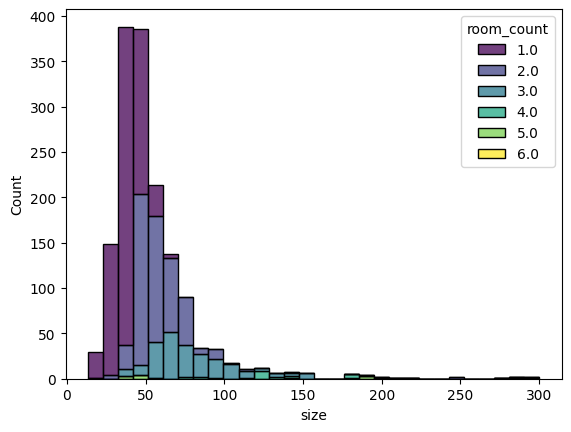

In [154]:
sns.histplot(
    data=olx_full_with_rooms,
    x="size",
    hue="room_count",
    multiple="stack",
    bins=30,
    palette="viridis",
)

<p>I'll use the mean values to determine the brackets</p>

In [155]:
room_bracket_1 = olx_full_with_rooms['size']<48
room_bracket_2 = (olx_full_with_rooms['size']>=48) & (olx_full_with_rooms['size']<69)
room_bracket_3 = (olx_full_with_rooms['size']>=69) & (olx_full_with_rooms['size']<108)
room_bracket_4 = (olx_full_with_rooms['size']>=108) & (olx_full_with_rooms['size']<150)
room_bracket_5 = (olx_full_with_rooms['size']>=150) & (olx_full_with_rooms['size']<200)
room_bracket_6 = (olx_full_with_rooms['size']>=200)
conditional_brackets = [
    room_bracket_1,
    room_bracket_2,
    room_bracket_3,
    room_bracket_4,
    room_bracket_5,
    room_bracket_6
]

room_labels = [1.0,2.0,3.0,4.0,5.0,6.0]

size_room_mapping = np.select(
    conditional_brackets,
    room_labels,
    default=np.nan
)

olx_full_with_rooms['room_count'] = np.where(
    olx_full_with_rooms['room_count'].notna(),
    olx_full_with_rooms['room_count'],
    size_room_mapping
)

<Axes: xlabel='size', ylabel='Count'>

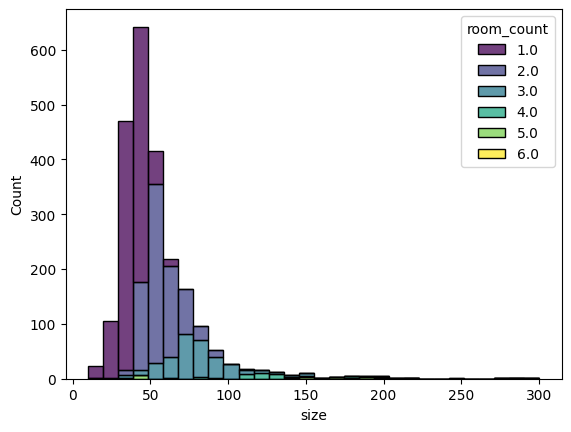

In [156]:
sns.histplot(
    data=olx_full_with_rooms,
    x="size",
    hue="room_count",
    multiple="stack",
    bins=30,
    palette="viridis",
)

##### City and district

In [157]:
def city_and_district(row):
    text = str(row['location'])
    if text.find(', ') != -1:
        city, district = text.split(', ', 1)
    else:
        city = text
        district = None
    return pd.Series([city, district])
   

In [158]:
olx_full_with_rooms[['city', 'district']] = olx_full_with_rooms.apply(city_and_district, axis=1)
olx_full_with_rooms.head()

price             location                                              title  size origin pets  room_count      city       district
0   8 800 грн.  Харьков, Салтовский  Сдам свою 2х. Ком. Новострой Гв. Широнинцев (С...  49.0    olx   no         2.0   Харьков     Салтовский
1   9 553 грн.             Черновцы  Здам 1 кімнатну, ЩЕРБАНЮКА (ПАРК ШЕВЧЕНКА) є з...  33.0    olx   no         1.0  Черновцы           None
2  15 000 грн.  Киев, Шевченковский  Оренда 1 кімн. квартири вул. Казарменна (Андрю...  33.0    olx   no         1.0      Киев  Шевченковский
3  35 000 грн.  Киев, Шевченковский                     Евро двушка з гарним ремонтом!  50.0    olx   no         2.0      Киев  Шевченковский
4  17 500 грн.   Одесса, Приморский                   Сдам долгосрочно СВОЮ евродвушку  70.0    olx   no         2.0    Одесса     Приморский

In [159]:
olx_full_with_rooms.drop(columns='location', inplace=True)

In [160]:
olx_full_with_rooms.head()

price                                              title  size origin pets  room_count      city       district
0   8 800 грн.  Сдам свою 2х. Ком. Новострой Гв. Широнинцев (С...  49.0    olx   no         2.0   Харьков     Салтовский
1   9 553 грн.  Здам 1 кімнатну, ЩЕРБАНЮКА (ПАРК ШЕВЧЕНКА) є з...  33.0    olx   no         1.0  Черновцы           None
2  15 000 грн.  Оренда 1 кімн. квартири вул. Казарменна (Андрю...  33.0    olx   no         1.0      Киев  Шевченковский
3  35 000 грн.                     Евро двушка з гарним ремонтом!  50.0    olx   no         2.0      Киев  Шевченковский
4  17 500 грн.                   Сдам долгосрочно СВОЮ евродвушку  70.0    olx   no         2.0    Одесса     Приморский

### Lun.ua

In [161]:
lun = pd.read_csv("lun.csv")
lun.drop(columns=['page', 'url'], inplace=True)

In [162]:
lun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34682 entries, 0 to 34681
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   price              30562 non-null  object
 1   location           30562 non-null  object
 2   location_discrete  30562 non-null  object
 3   room               30557 non-null  object
 4   title              34443 non-null  object
 5   label              34682 non-null  object
 6   size               34678 non-null  object
 7   city_name          34682 non-null  object
 8   origin             34682 non-null  object
dtypes: object(9)
memory usage: 2.4+ MB


In [163]:
lun.head()

price                          location                                  location_discrete       room                                              title              label               size city_name origin
0   16 500 грн    проспект Петра Григоренка, 3-А                            Позняки,Дарницький,Київ  3 кімнати  Здається 3-х к. Кв. по просп. Петра Григоренка...  можна з тваринами    77 / 43 / 12 м²      Київ    lun
1   42 000 грн             вулиця Антоновича, 74  ЖК New York Concept House,Нова забудова,Голосі...  1 кімната  Без комісії здаю сучасну 1-кімнатну квартира в...  можна з тваринами    51 / 12 / 25 м²      Київ    lun
2          NaN                               NaN                                                NaN        NaN                                           No Title           No Label           No Title      Київ    lun
3  104 577 грн              Турівська вулиця, 31                             Поділ,Подільський,Київ  3 кімнати  Історичний центр міста\n\n200 м2\n8/10 поверх\...  можна з тваринами  200 / 100 / 16 м²      Київ    lun
4   13 500 грн  вулиця Геннадія Афанасьєва, 13-А                       Нова Дарниця,Дарницький,Київ  1 кімната  Оренда довгострокова.\nПоверх 4 - з видом на Д...           No Label     33 / 18 / 7 м²      Київ    lun

In [164]:
lun_maks = lun.duplicated(subset=["title", "price", "location", "size"], keep='first')
print("Number of duplicates in lun dataset:", lun_maks.sum())

lun_2 = lun.copy()
lun_2 = lun_2.drop_duplicates(subset=["title", "price", "location", "size"], keep='first')
lun_2_mask = lun_2.duplicated(subset=["title", "price", "location", "size"], keep='first')
print("Number of duplicates in lun dataset after drop:", lun_2_mask.sum())

Number of duplicates in lun dataset: 8799
Number of duplicates in lun dataset after drop: 0


In [165]:
lun.isnull().sum().sort_values(ascending=False)

room                 4125
price                4120
location             4120
location_discrete    4120
title                 239
size                    4
label                   0
city_name               0
origin                  0
dtype: int64

<p style="max-width:75ch;text-align:justify;">
After examining the Lun data, I can see a few things that are worth doing:
<ul style="max-width:75ch">
    <li>NaN rows. They are non-recoverable. They are also just a byproduct of the data collection method, and are not a vital data in any capacity. So we can drop them.
    </li>
    <li>Try and fix as much missing data as possible.</li>
    <li>If some row has no price, or any two combination of room, size, location/location_discrete/title - it's dropable</li>
    <li>label column has some rows set to No Label, that's worth changing to 'No'/'Yes' and renaming this column to 'pets'</li>
    <li>Leaving only number of rooms in the room column</li>
    <li>Leaving only floor size in the size column</li>
    <li>Transforming location_discrete into district</li>
</ul>
</p>

In [166]:
lun_mask = lun['price'].isna() & lun['room'].isna() & lun['location'].isna() & lun['location_discrete'].isna()

print('Number of dropable rows:',lun.loc[lun_mask].shape[0],'\nTotal rows:', lun.shape[0])

lun = lun.dropna(subset=['price', 'room', 'location', 'location_discrete'], how='all')

print('Number of rows after dropping:', lun.shape[0])

print("\nNumber of null rows, after dropping:\n",lun.isnull().sum().sort_values(ascending=False))

Number of dropable rows: 4120 
Total rows: 34682
Number of rows after dropping: 30562

Number of null rows, after dropping:
 title                239
room                   5
size                   4
price                  0
location_discrete      0
location               0
label                  0
city_name              0
origin                 0
dtype: int64


<p style='max-width:75ch;'>We can omit recovering the title, because it's not as vital as other parts. It's still worth checing if 5 missing rooms don't overlap with 4 missing sizes</p>

In [167]:
lun_mask_nonrecoverable = lun['room'].isna() & lun['size'].isna()

print("\nNumber of rows with non-recoverable data:", lun_mask_nonrecoverable.sum())

lun = lun.dropna(subset=['room', 'size'], how='all')
print(f"Null rows after dropping non-recoverable data:\n{lun.isnull().sum().sort_values(ascending=False)}")


Number of rows with non-recoverable data: 4
Null rows after dropping non-recoverable data:
title                239
room                   1
price                  0
location_discrete      0
location               0
label                  0
size                   0
city_name              0
origin                 0
dtype: int64


#### Fixing pets column

In [168]:
lun_title_mask = lun['title'].isna()
print('Number of rows with missing noncrucial data:', lun.loc[lun_mask].shape[0])

lun.loc[lun_title_mask, 'title'] = 'No title'

print('Number of rows with missing noncrucial data after fillna:', lun.loc[lun['title'].isna()].shape[0])

Number of rows with missing noncrucial data: 0
Number of rows with missing noncrucial data after fillna: 0


In [169]:
lun.rename(columns={'room': 'room_count', 'label':"pets"}, inplace=True)

print('Initial values of pets column:\n', lun['pets'].value_counts())   


lun_condition = lun['pets'].str.contains('можна з тваринами', case=False, na=False),
lun['pets']='No'
lun_condition
if lun_condition[0].any():
    lun.loc[lun_condition[0], 'pets'] = 'Yes'
print("Pets column after condition check:\n", lun['pets'].value_counts()) 


Initial values of pets column:
 pets
No Label                             21576
можна з тваринами                     5242
власник                               1917
генератор                             1002
можна з тваринамигенератор             441
власникможна з тваринами               334
власникгенератор                        36
власникможна з тваринамигенератор       10
Name: count, dtype: int64
Pets column after condition check:
 pets
No     24531
Yes     6027
Name: count, dtype: int64


#### Fixing number of rooms and size columns

In [170]:
lun['room_count']= lun['room_count'].str.slice(0, 1).astype(float)
lun['size'] = lun['size'].str.replace(r'(/.*)|( .*)','', regex=True).str.strip().astype(float)
lun.head()

price                          location                                  location_discrete  room_count                                              title pets   size city_name origin
0   16 500 грн    проспект Петра Григоренка, 3-А                            Позняки,Дарницький,Київ         3.0  Здається 3-х к. Кв. по просп. Петра Григоренка...  Yes   77.0      Київ    lun
1   42 000 грн             вулиця Антоновича, 74  ЖК New York Concept House,Нова забудова,Голосі...         1.0  Без комісії здаю сучасну 1-кімнатну квартира в...  Yes   51.0      Київ    lun
3  104 577 грн              Турівська вулиця, 31                             Поділ,Подільський,Київ         3.0  Історичний центр міста\n\n200 м2\n8/10 поверх\...  Yes  200.0      Київ    lun
4   13 500 грн  вулиця Геннадія Афанасьєва, 13-А                       Нова Дарниця,Дарницький,Київ         1.0  Оренда довгострокова.\nПоверх 4 - з видом на Д...   No   33.0      Київ    lun
5   14 000 грн         бульвар Лесі Українки, 12                    Черепанова гора,Печерський,Київ         1.0  В довгострокову оренду здається 1к квартира, з...   No   37.0      Київ    lun

#### Fixing locations and title

In [171]:
lun['location_discrete'] = lun['location_discrete'].str.replace(r',\s*[^,]*$', '', regex=True)

lun['district'] = lun['location_discrete'].str.replace(r'.*(,\s*.*)', r'\1', regex=True).str.replace(',','')
lun['title']= lun['title'].str.replace('\n', ' ')

lun.drop(columns=['location_discrete'], inplace=True)
lun.head()

price                          location  room_count                                              title pets   size city_name origin       district
0   16 500 грн    проспект Петра Григоренка, 3-А         3.0  Здається 3-х к. Кв. по просп. Петра Григоренка...  Yes   77.0      Київ    lun     Дарницький
1   42 000 грн             вулиця Антоновича, 74         1.0  Без комісії здаю сучасну 1-кімнатну квартира в...  Yes   51.0      Київ    lun  Голосіївський
3  104 577 грн              Турівська вулиця, 31         3.0  Історичний центр міста  200 м2 8/10 поверх 2 с...  Yes  200.0      Київ    lun    Подільський
4   13 500 грн  вулиця Геннадія Афанасьєва, 13-А         1.0  Оренда довгострокова. Поверх 4 - з видом на Да...   No   33.0      Київ    lun     Дарницький
5   14 000 грн         бульвар Лесі Українки, 12         1.0  В довгострокову оренду здається 1к квартира, з...   No   37.0      Київ    lun     Печерський

### Dim ria

In [172]:
dim_ria= dim_ria.drop(columns=['page', 'url'])

In [173]:
dim_ria.head()

price                               location                     location_discrete                                              title                                              label   origin
0   66 832 грн  ЖК Микільський град·Дніпровський·Київ        вул. Микільсько-Слобідська, 1А  \n                    Пропонується в оренду чу...                    3 кімнати 123 м² 13 поверх з 26  dim_ria
1   62 655 грн               ЖК Great·Дарницький·Київ                 наб. Дніпровська, 15К  \n                    ПЕРША ЗДАЧА!\n\nПропонує...                      1 кімната 80 м² 7 поверх з 26  dim_ria
2   58 478 грн   ЖК Hoffmann Haus·Шевченківський·Київ              вул. Золотоустівська, 34  \n                    Пропонується на оренду 3...                      3 кімнати 80 м² 7 поверх з 25  dim_ria
3  133 664 грн               Деміївська·Деміївка·Київ                  вул. Голосіївська, 4  \n                    Пропонується в оренду дв...           4 кімнати 245 м² 8 поверх з 9 Без тварин  dim_ria
4   21 000 грн                 Шулявська·Шулявка·Київ  вул. Олекси Тихого(Виборзька), 80/17  \n                    У довгострокову оренду з...   2 кімнати 44.4 м² 2 поверх з 5 Можна з тваринами  dim_ria

In [174]:
dim_ria_mask = dim_ria.duplicated(subset=["title", "price", "location", "label"], keep='first')
print("Number of duplicates in dim_ria dataset:", dim_ria_mask.sum())

dim_ria = dim_ria.drop_duplicates(subset=["title", "price", "location", "label"], keep='first')
dim_ria_mask_2 = dim_ria.duplicated(subset=["title", "price", "location", "label"], keep='first')
print("Number of duplicates in dim_ria dataset after drop:", dim_ria_mask_2.sum())

Number of duplicates in dim_ria dataset: 1207
Number of duplicates in dim_ria dataset after drop: 0


<p style="max-width:75ch;align-text:justify;">
After looking at the dim.ria data, I see that I need to remove some data and separate data from some columns
<ul>
    <li>Remove \n from title</li>
    <li>Separate location into City and District</li>
    <li>Separate label into rooms, size and pet allowance</li>
</ul>
</p>

#### Removing the '\n'

In [175]:
dim_ria['title'] = dim_ria['title'].str.replace('\n', ' ')

#### Separatring location into city and district

In [176]:
dim_ria['city'] = dim_ria['location'].str.extract(r'·([^·]*)$')

dim_ria['district'] = dim_ria['location'].str.replace(r'·[^·]*$', '', regex=True).str.replace('·', ' ')
dim_ria= dim_ria.drop(columns=['location'])

dim_ria.head()

price                     location_discrete                                              title                                              label   origin  city                          district
0   66 832 грн        вул. Микільсько-Слобідська, 1А                       Пропонується в оренду чуд...                    3 кімнати 123 м² 13 поверх з 26  dim_ria  Київ  ЖК Микільський град Дніпровський
1   62 655 грн                 наб. Дніпровська, 15К                       ПЕРША ЗДАЧА!  Пропонуєтьс...                      1 кімната 80 м² 7 поверх з 26  dim_ria  Київ               ЖК Great Дарницький
2   58 478 грн              вул. Золотоустівська, 34                       Пропонується на оренду 3 ...                      3 кімнати 80 м² 7 поверх з 25  dim_ria  Київ   ЖК Hoffmann Haus Шевченківський
3  133 664 грн                  вул. Голосіївська, 4                       Пропонується в оренду дво...           4 кімнати 245 м² 8 поверх з 9 Без тварин  dim_ria  Київ               Деміївська Деміївка
4   21 000 грн  вул. Олекси Тихого(Виборзька), 80/17                       У довгострокову оренду зд...   2 кімнати 44.4 м² 2 поверх з 5 Можна з тваринами  dim_ria  Київ                 Шулявська Шулявка

#### Separating label

In [177]:
dim_ria['pets'] = dim_ria['label'].str.contains('можна з тваринами', case=False, na=False).replace({True: 'Yes', False: 'No'})

dim_ria['size'] = dim_ria['label'].str.extract(r'(\d+)\s*м²', expand=False).astype(float)

dim_ria['room_count'] = dim_ria['label'].str.extract(r'(\d+)\s*кімнат|кімнати|кімната', expand=False).astype(float)

dim_ria.head()
dim_ria_mask = dim_ria['pets'].isna() | dim_ria['size'].isna() | dim_ria['room_count'].isna()


dim_ria.loc[dim_ria_mask].head()

price location_discrete     title     label   origin city district pets  size  room_count
20   NaN               NaN  No Title  No labes  dim_ria  NaN      NaN   No   NaN         NaN

Label column still contais some usefull information, about generator, floor, weather you are renting directly from the porperty owner etcetera

In [178]:
dim_ria.head()

price                     location_discrete                                              title                                              label   origin  city                          district pets   size  room_count
0   66 832 грн        вул. Микільсько-Слобідська, 1А                       Пропонується в оренду чуд...                    3 кімнати 123 м² 13 поверх з 26  dim_ria  Київ  ЖК Микільський град Дніпровський   No  123.0         3.0
1   62 655 грн                 наб. Дніпровська, 15К                       ПЕРША ЗДАЧА!  Пропонуєтьс...                      1 кімната 80 м² 7 поверх з 26  dim_ria  Київ               ЖК Great Дарницький   No   80.0         1.0
2   58 478 грн              вул. Золотоустівська, 34                       Пропонується на оренду 3 ...                      3 кімнати 80 м² 7 поверх з 25  dim_ria  Київ   ЖК Hoffmann Haus Шевченківський   No   80.0         3.0
3  133 664 грн                  вул. Голосіївська, 4                       Пропонується в оренду дво...           4 кімнати 245 м² 8 поверх з 9 Без тварин  dim_ria  Київ               Деміївська Деміївка   No  245.0         4.0
4   21 000 грн  вул. Олекси Тихого(Виборзька), 80/17                       У довгострокову оренду зд...   2 кімнати 44.4 м² 2 поверх з 5 Можна з тваринами  dim_ria  Київ                 Шулявська Шулявка  Yes    4.0         2.0

### Connecting and fine-tuning the data

Right now different dataframes have different columns and in different order

In [179]:
print("Information about olx:\n", olx_full_with_rooms.info())
print("\nInformation about lun:\n", lun.info())
print("\nInformation about dim_ria:\n", dim_ria.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2306 entries, 0 to 2581
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       2306 non-null   object 
 1   title       2306 non-null   object 
 2   size        2306 non-null   float64
 3   origin      2306 non-null   object 
 4   pets        2306 non-null   object 
 5   room_count  2306 non-null   float64
 6   city        2306 non-null   object 
 7   district    1497 non-null   object 
dtypes: float64(2), object(6)
memory usage: 162.1+ KB
Information about olx:
 None
<class 'pandas.core.frame.DataFrame'>
Index: 30558 entries, 0 to 34681
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       30558 non-null  object 
 1   location    30558 non-null  object 
 2   room_count  30557 non-null  float64
 3   title       30558 non-null  object 
 4   pets        30558 non-null  object 
 5   size       

I will rearrange the columns in the following way:
1. price 
2. size
3. rooms
4. city
5. district
6. pets
7. title
8. location - can be set to na
9. label - can be set to na
10. origin

In [180]:
print('OLX\n',olx_full_with_rooms.head())
print('\nLUN\n',lun.head())
print('\nDIM RIA\n',dim_ria.head())

OLX
          price                                              title  size origin pets  room_count      city       district
0   8 800 грн.  Сдам свою 2х. Ком. Новострой Гв. Широнинцев (С...  49.0    olx   no         2.0   Харьков     Салтовский
1   9 553 грн.  Здам 1 кімнатну, ЩЕРБАНЮКА (ПАРК ШЕВЧЕНКА) є з...  33.0    olx   no         1.0  Черновцы           None
2  15 000 грн.  Оренда 1 кімн. квартири вул. Казарменна (Андрю...  33.0    olx   no         1.0      Киев  Шевченковский
3  35 000 грн.                     Евро двушка з гарним ремонтом!  50.0    olx   no         2.0      Киев  Шевченковский
4  17 500 грн.                   Сдам долгосрочно СВОЮ евродвушку  70.0    olx   no         2.0    Одесса     Приморский

LUN
          price                          location  room_count                                              title pets   size city_name origin       district
0   16 500 грн    проспект Петра Григоренка, 3-А         3.0  Здається 3-х к. Кв. по просп. Петра Григоренк

In [181]:
standard_columns = ['price', 'size', 'room_count', 'city', 'district', 'pets', 'title', 'location', 'label', 'origin']

olx_full_with_rooms['location'] = 'Not specified'
olx_full_with_rooms['label'] = 'Not specified'
olx_standardized = olx_full_with_rooms[standard_columns]

lun =lun.rename(columns={'city_name':'city'})
lun['label']= 'Not specified'
lun_standardized = lun[standard_columns]

dim_ria=dim_ria.rename(columns={'location_discrete':'location'})
dim_ria_standardized = dim_ria[standard_columns]


In [182]:
rental_data = pd.concat(
    [olx_standardized, lun_standardized, dim_ria_standardized],
    ignore_index=True,
)

A few little steps before starting the analsis. 
I'd like to 
- convert price to float
- standartize cites
- add region
- remove mismatch in pets column

In [183]:
rental_data['price'] = rental_data['price'].str.replace(r'грн\.|грн', '',regex=True).str.replace(' ','').astype(float)

In [ ]:
city_labels = {
    "Киев": "Київ",
    "Запорожье": "Запоріжжя", 
    "Одесса": "Одеса",
    "Кременчук": "Кременчук",
    "Черновцы": "Чернівці",
    "Яремче": "Яремче",
    "Львов": "Львів",
    "Николаев": "Миколаїв",
    "Днепр": "Дніпро",
    "Харьков": "Харків",
    "Черкассы": "Черкаси",
    "Винники (Львів)": "Львів",
    "Брюховичі (Львів)": "Львів",
    "Угорники (Івано-Франківськ)": "Івано-Франківськ",
    "Чагор (Чернівці)": "Чернівці",
    "Ивано-Франковск": "Івано-Франківськ",
    "Софиевская Борщаговка": "Софіївська Борщагівка",
    "Борисполь": "Бориспіль",
    "Крюковщина": "Крюківщина",
    "Ирпень": "Ірпінь",
    "Чернигов": "Чернігів",
    "Сумы": "Суми",
    "Кропивницкий": "Кропивницький",
    "Вышгород": "Вишгород",
    "Кулиничи": "Кулиничі",
    "Винница": "Вінниця",
    "Брюховичи": "Брюховичі",
    "Оболонь": "Оболонь",
    "Фонтанка (Одеса)": "Одеса", 
    "Микитинці (Івано-Франківськ)": "Івано-Франківськ", 
    "Крижанівка (Одеса)": "Одеса", 
    "Коцюбинське (Київ)": "Київ", 
    "Підгірці (Обухів)": "Київ", 
    "Підгірці (Київ)": "Київ", 
    "Чайки (Бучанський)": "Буча",
    "Горишные Плавни":"Горішні Плавні",
}

rental_data['city'] = rental_data['city'].replace(city_labels)
print('Unique cities after replacement:\n', rental_data['city'].value_counts())
print('\nNumber of unique cities after replacement:', len(rental_data['city'].unique()))

In [185]:
wiki_url = f'https://uk.wikipedia.org/wiki/%D0%9C%D1%96%D1%81%D1%82%D0%B0_%D0%A3%D0%BA%D1%80%D0%B0%D1%97%D0%BD%D0%B8_(%D0%B7%D0%B0_%D0%B0%D0%BB%D1%84%D0%B0%D0%B2%D1%96%D1%82%D0%BE%D0%BC)'

data = pd.read_html(wiki_url,header=0, index_col=0)

city_region=data[1].drop(columns=['Ч-сть населення, осіб','Час заснування','Площа[джерело?] (км²)'])

city_region.head()

Місто               Область, АРК
Герб                                     
NaN   Авдіївка           Донецька область
NaN    Алмазна          Луганська область
NaN     Алупка  Автономна Республіка Крим
NaN     Алушта  Автономна Республіка Крим
NaN   Алчевськ          Луганська область

In [186]:
rental_data['pets'] = rental_data['pets'].replace({'yes': 'Yes', 'no': 'No'})

In [ ]:
rental_data_regions = rental_data.merge(city_region, left_on='city', right_on='Місто', how='left')
rental_data_regions=rental_data_regions.rename(columns={'Область, АРК':'region'})

rental_data_regions = rental_data_regions.drop(columns=['Місто'])

rental_data_regions.head()

In [188]:
rental_data_regions.loc[rental_data_regions['region'].isna(),'region'] = 'Села'

## Exploratory DA

It's worth trying to get a birds' view on the situation, and I have one beloved tool specificaly for that 😍

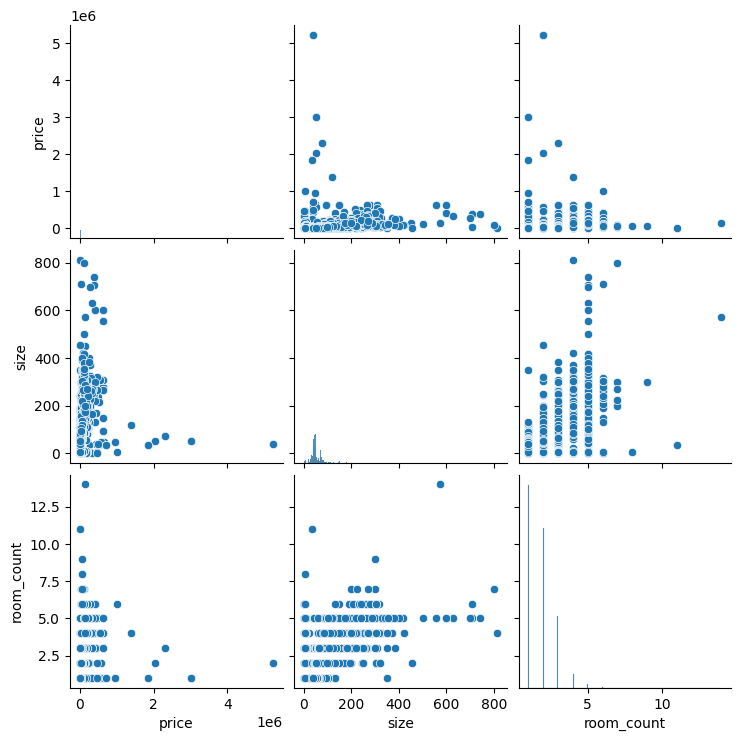

In [189]:
sns.pairplot(rental_data)

<p style='max-width:75ch;text-align:justify;'>
Well not that impressive, not that many numeric columns. But still we can see a clear correlation between the price and size/room count.
I'm anyway interested in a few other things except for the obvious size/price correlation.
</p>
<ul>
    <li>Which cities take the biggest % on top of their price?</li>
    <li>Should I move from Kyiv🥺</li>
    <li>What affects the price?</li>
    <li>How can I choose the best option for the least amount of $?</li>
</ul>
<p>For removal of bias in the future, I'll take alpha=0.02</p>

In [190]:
alpha = 0.02

<p>

</p>

### City analysis

<p style='max-width:75ch;text-align:justify;'>By 'take the biggest %', is something like 'city tax' or 'prestige tax'. It's easier to explain by example. Imagine 2 room apartment with no pets allowed, 2k.m. from the center and 5 minutes from the subway in Kyiv, Lviv nad Kharkiv (imagine also that they all have a subway). They would have a different price, I want to find that ilusive % that each city takes.</p>
</br>
<p style='max-width:75ch;text-align:justify;'>To find weather there is even a significant differenvce between city prices, I'll use ANOVA test. ANOVA shows weather there is any significant difference at all, if there will be, we should use pairwise test to see which pairs differ. I'll import pingouin for easier statistical tests.</p>

In [191]:
import pingouin as pg

In [192]:
rental_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41657 entries, 0 to 41656
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       41656 non-null  float64
 1   size        41656 non-null  float64
 2   room_count  41655 non-null  float64
 3   city        41320 non-null  object 
 4   district    40847 non-null  object 
 5   pets        41657 non-null  object 
 6   title       41657 non-null  object 
 7   location    41655 non-null  object 
 8   label       41657 non-null  object 
 9   origin      41657 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.2+ MB


In [193]:
anova_results = pg.anova(data=rental_data, dv="price", between="city",detailed=True)

print("ANOVA results:\n", anova_results)

if anova_results['p-unc'].values[0] < alpha:
    print("There are significant differences in rental prices between cities.")
else:
    print("No significant differences in rental prices between cities.")


ANOVA results:
    Source            SS     DF            MS         F  p-unc       np2
0    city  6.507494e+12    154  4.225646e+10  13.67975    0.0  0.048685
1  Within  1.271578e+14  41165  3.088979e+09       NaN    NaN       NaN
There are significant differences in rental prices between cities.


<p>

</p>

<p style="max-width:75ch;text-align:justify;">
We can see that `p-unc` or p-value is 0, it's much lower that alpha (0.02). That's why we must proceed with the pairwise comparison. It also feels like an error, so I will use scipy to double-check the result
</p>

In [194]:
from scipy import stats

city_groups = [group['price'].values for name, group in rental_data.groupby('city')]

f_stat,p_val_scipy =stats.f_oneway(*city_groups)

print("Comparison of ANOVA results:")
print(f"Pingouin p-value: {anova_results['p-unc'].values[0]}")
print(f"Scipy p-value: {p_val_scipy}")
print(f"Pingouin F-stat: {anova_results['F'].values[0]:.6f}")
print(f"Scipy F-stat: {f_stat:.6f}")

if p_val_scipy == 0.0:
    print("Both methods show p-value at 0")
    print("This confirms EXTREMELY significant differences between cities")
else:
    print(f"Scipy shows: {p_val_scipy:.2e}")

Comparison of ANOVA results:
Pingouin p-value: 0.0
Scipy p-value: 0.0
Pingouin F-stat: 13.679750
Scipy F-stat: 13.679750
Both methods show p-value at 0
This confirms EXTREMELY significant differences between cities


<p style='max-width:75ch;text-align:justify;'>Because scipy is a powerhouse in statistics, and it returns same results as pingouin, the p-value is 0 (or just rounded down by the machine). We can comfortably proceed with pairwise tests </br> Note: It's not essential to run the script below, it can take 5+ minutes to run and doesn't show a lot of information, if we were to have 10-30, or some meaningful number of cities, it would be much more useful</p>

In [195]:
# pairwise_result = pg.pairwise_tests(
#     data=rental_data,
#     dv='price',
#     between='city',
#     padjust='bonf'
# )
# print("Pairwise comparison results:\n", pairwise_result)

d:\pythong\venv\Lib\site-packages\pingouin\parametric.py:257: RuntimeWarning: Degrees of freedom <= 0 for slice
  vx, vy = x.var(ddof=1), y.var(ddof=1)
d:\pythong\venv\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\pythong\venv\Lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / dof)
d:\pythong\venv\Lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / dof)
d:\pythong\venv\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\pythong\venv\Lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # t

Pairwise comparison results:
       Contrast                            A                            B  Paired  Parametric           T           dof alternative          p-unc         p-corr p-adjust        BF10      hedges
0         city                      Іванків             Івано-Франківськ   False        True         NaN      1.000000   two-sided            NaN            NaN     bonf         nan         NaN
1         city                      Іванків                       Ізмаїл   False        True         NaN      0.000000   two-sided            NaN            NaN     bonf         nan         NaN
2         city                      Іванків                       Ірпінь   False        True         NaN      1.000000   two-sided            NaN            NaN     bonf         nan         NaN
3         city                      Іванків                     Авангард   False        True         NaN      1.000000   two-sided            NaN            NaN     bonf         nan         NaN


In [196]:
# significant_pairs = pairwise_result[pairwise_result['p-corr'] < alpha].copy()

# print(f"Significant comparisons: {len(significant_pairs)} out of {len(pairwise_result)}")
# print(f"Percentage significant: {len(significant_pairs)/len(pairwise_result)*100:.1f}%")

# significant_pairs_sorted = significant_pairs.sort_values('p-corr')
# print("\nTop 10 most significant differences:")
# print(significant_pairs_sorted[['A', 'B', 'p-corr', 'hedges']].head(10))

### Region Analysis

<p style='max-width:75ch;align-text:justify;'>Because city level pair test did not give us a lot of information, and ANOVA resulted with p-value of 0, I would like to step up a bit, and do the same thing for regions</p>

In [197]:
region_results = pg.anova(
    data=rental_data_regions,dv="price", between="region")

print("\nANOVA results for regions:\n", region_results)

if region_results['p-unc'].values[0] < alpha:
    print("There are significant differences in rental prices between regions.")
else:
    print("No significant differences in rental prices between regions.")
    


ANOVA results for regions:
    Source  ddof1  ddof2         F  p-unc       np2
0  region     24  42064  85.29177    0.0  0.046406
There are significant differences in rental prices between regions.


<p>We get the same p-value of 0, with even higher F-statistic</p>

In [198]:
cleaned_rental_data_regions = rental_data_regions.dropna(subset=['price', 'region'])

# 2. Create groups from the cleaned data
region_groups_cleaned = [
    group['price'].values 
    for name, group in cleaned_rental_data_regions.groupby('region')
]
# 3. Filter out groups with less than 2 entries
#    to ensure valid ANOVA input
valid_region_groups = [g for g in region_groups_cleaned if len(g) >= 2]

f_stat_region_scipy = float('nan')
p_val_region_scipy = float('nan')

if len(valid_region_groups) >= 2:
    # Calculate F-test for regions using Scipy on cleaned and validated data
    f_stat_region_scipy, p_val_region_scipy = stats.f_oneway(*valid_region_groups)
else:
    print("Scipy: Not enough valid groups with sufficient data after cleaning for ANOVA.")


print("Comparison of REGION ANOVA results (Scipy with explicit NaN cleaning):")
print(f"Pingouin p-value: {region_results['p-unc'].values[0]}")
print(f"Scipy p-value: {p_val_region_scipy}")
print(f"Pingouin F-stat: {region_results['F'].values[0]:.6f}")
print(f"Scipy F-stat: {f_stat_region_scipy:.6f}")

if not np.isnan(p_val_region_scipy) and p_val_region_scipy == 0.0:
    print("Both methods likely show p-value at 0")
elif not np.isnan(p_val_region_scipy):
    print(f"Scipy shows: {p_val_region_scipy:.2e}")

Comparison of REGION ANOVA results (Scipy with explicit NaN cleaning):
Pingouin p-value: 0.0
Scipy p-value: 0.0
Pingouin F-stat: 85.291770
Scipy F-stat: 85.291770
Both methods likely show p-value at 0


<p>Still 0, bu we can proceed with pairwise test</p>

In [199]:
# pairwise_result_regions = pg.pairwise_tests(
#     data=rental_data_regions,
#     dv='price',
#     between='region',
#     padjust='bonf'
# )
# print("Pairwise comparison results:\n", pairwise_result_regions)

<p style="max-width:75ch;text-align:justify;">300 rows, that would be much easier to interpret, but I don't have 6 hours to do that. I'll focus on largest effects </p>

In [200]:
# significant_pairs_regions = pairwise_result_regions[pairwise_result_regions['p-corr']<alpha].copy()

# significant_pairs_sorted_regions = significant_pairs_regions.reindex(
#     significant_pairs_regions['hedges'].abs().sort_values(ascending=False).index
# )

# print("Top 10 most significant differences between regions:")
# print(significant_pairs_sorted_regions[['A', 'B', 'p-corr', 'hedges']].head(10))

# high_difference = significant_pairs_sorted_regions[significant_pairs_sorted_regions['hedges'].abs() > 0.8]
# print(f"\nRegion pairs with high practical differences: {len(high_difference)}")


### What affects the price?

<p style="max-width:75ch;text-align:justify;">I will first find correlation between the price and any numerical columns. Then I would perform ANOVAs, to find if there is a statisticaly significant effect.</p>

#### Numerical data
But before proceeding, it's worth removing any outliers to better see the relations.

Text(0.5, 0.98, 'Scatter Plots of Rental Data')

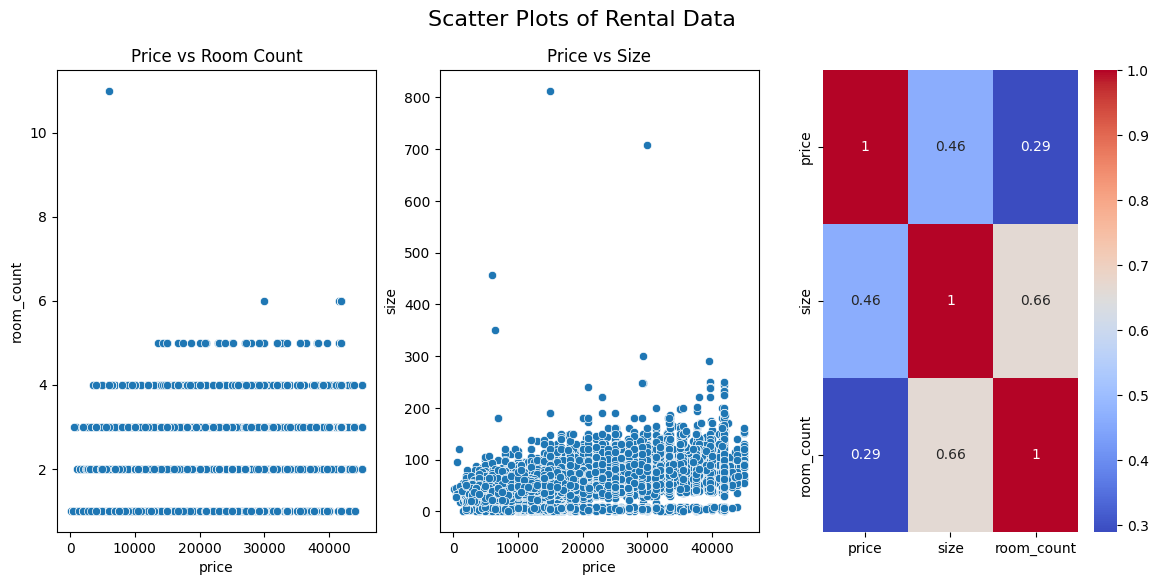

In [210]:
rental_data_regions_price_q1 = rental_data_regions['price'].quantile(0.25)
rental_data_regions_price_q3 = rental_data_regions['price'].quantile(0.75)
rental_data_regions_price_iqr = rental_data_regions_price_q3 - rental_data_regions_price_q1

rental_data_mask = (
    (rental_data_regions['price'] < (rental_data_regions_price_q1 - 1.5 * rental_data_regions_price_iqr)) |
    (rental_data_regions['price'] > (rental_data_regions_price_q3 + 1.5 * rental_data_regions_price_iqr))
)
rental_data_regions_no_outliers = rental_data_regions[~rental_data_mask]


fig, axes = plt.subplots(1, 3, figsize=(14, 6))


sns.scatterplot(data=rental_data_regions_no_outliers,x='price',y='room_count',ax=axes[0])
axes[0].set_title('Price vs Room Count')

sns.scatterplot(data=rental_data_regions_no_outliers,x='price',y='size',ax=axes[1])
axes[1].set_title('Price vs Size')

sns.heatmap(rental_data_regions_no_outliers[['price', 'size', 'room_count']].corr(), annot=True, cmap='coolwarm', ax=axes[2])

fig.suptitle('Scatter Plots of Rental Data', fontsize=16)

<p style="max-width:75ch;text-align:justify">
The correlation of 0.46 confirms a moderate linear relationship. Bigger rentals generally cost more. In the scatter plot for Price vs Size, there is an upward spread, indicating the moderate trend. Size however doesn't contribute to the price as much. 
</p>

#### Categorical data


=== PETS effects ===
              mean   median           std  count
pets                                            
Yes   25965.554541  16157.0  36173.770444   9094
No    23033.206645  14899.0  60795.673525  32989
Both  11833.166667   9000.0   9261.155444      6
ANOVA F-statistic: 9.7707, p-value: 5.7230e-05
Significant differences for pets (p < 0.02)


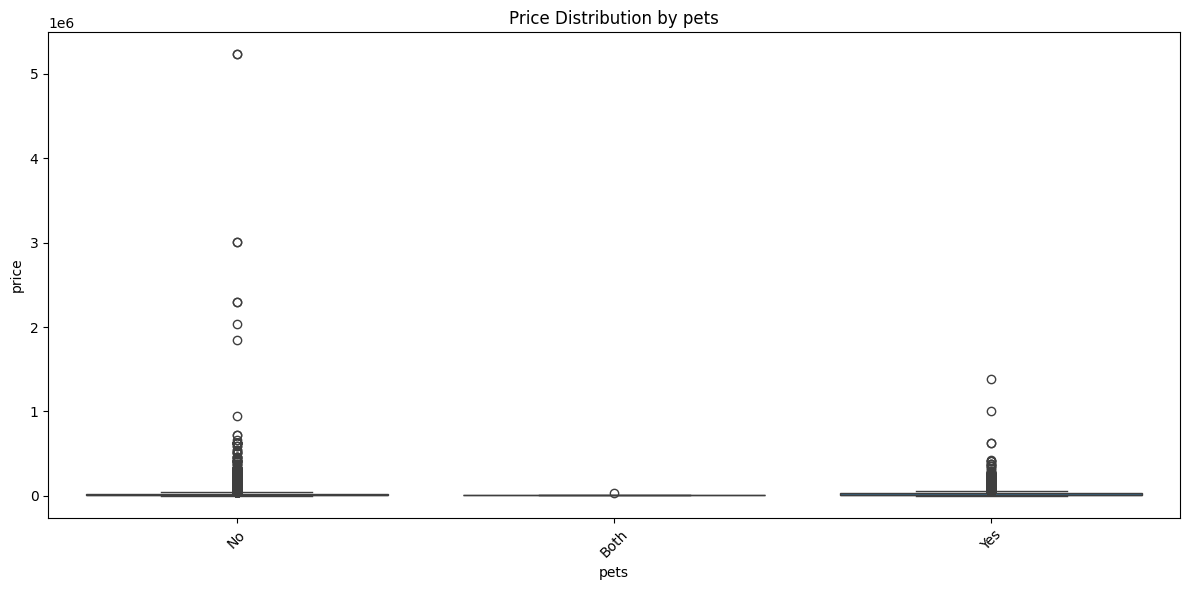


=== ORIGIN effects ===
                 mean   median           std  count
origin                                             
dim_ria  26201.246111  16000.0  39456.611713   8935
lun      23277.203752  15000.0  61779.116656  30812
olx      19094.308284  12999.0  31165.260069   2342
ANOVA F-statistic: 17.4658, p-value: 2.6174e-08
Significant differences for origin (p < 0.02)


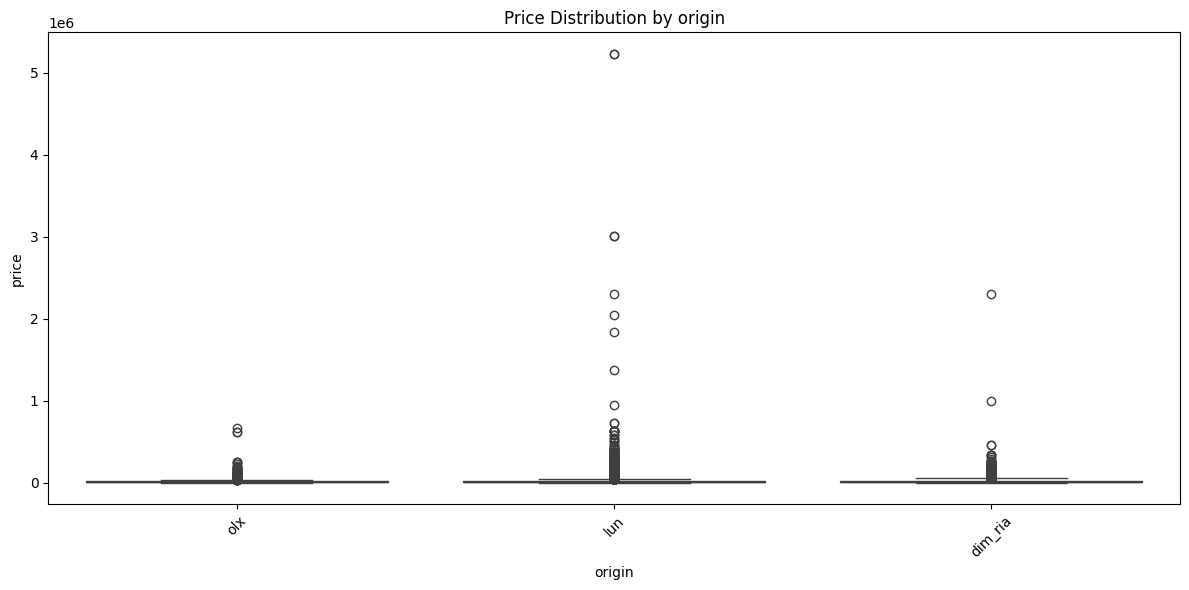

In [209]:
categorical_vars = ['pets', 'origin']

for var in categorical_vars:
    print(f"\n=== {var.upper()} effects ===")
    
    # Basic statistics
    price_by_category = rental_data_regions.groupby(var)['price'].agg(['mean', 'median', 'std', 'count'])
    price_by_category = price_by_category.sort_values('mean', ascending=False)
    print(price_by_category)
    
    # Statistical test (ANOVA)
    if rental_data_regions[var].nunique() > 1:
        groups = [group['price'].dropna().values for name, group in rental_data_regions.groupby(var) 
                 if len(group['price'].dropna()) > 1]
        
        if len(groups) > 1:
            f_stat, p_value = stats.f_oneway(*groups)
            print(f"ANOVA F-statistic: {f_stat:.4f}, p-value: {p_value:.4e}")
            if p_value < alpha:
                print(f"Significant differences for {var} (p < {alpha})")
            else:
                print(f"No significant differences for {var} (p >= {alpha})")
    
    # Visualization
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=rental_data_regions, x=var, y='price')
    plt.xticks(rotation=45)
    plt.title(f'Price Distribution by {var}')
    plt.tight_layout()
    plt.show()

<p style='max-width:75ch;text-align:justify'>
Rentals that allow pets have the highest average and median prices, followed by rentals that do not allow pets. The ANOVA F-statistic of 9.7707 with a p-value of 5.7230e-05 (which is less than 0.02) confirms that there are significant differences in rental prices across different pet policies.
</br>
Listings from dim_ria have the highest average and median prices, lun listings follow with intermediate prices, and olx listings show the lowest average and median prices. The ANOVA F-statistic of 17.4658 with an extremely small p-value of 2.6174e-08 (also less than 0.02) demonstrates that there are highly significant differences in rental prices across these origin platforms.
</p>

### How can I choose the best option for the least amount of $?

<p style="max-width:75ch;text-align:justify;">I'd like to live in Kyiv, somewhere close to the uni and that's the only preference I have. I don't want to spend more that I need to for an apartment. From the analysis above, it's obvious that I should look for a listing on 'olx' (I'm sceptical of olx in general, so I'll also use second cheapest option - lun), and search specifically for places that do not allow pets. I'm not planning on living with someone in the near future, and neither do I have a pet, this 1-2 rooms is the most I would ever need. So what would be a median price for <b>me</b>?</p> <b>what's my best bet?</b>

In [214]:
kyiv = rental_data_regions[rental_data_regions["city"] == "Київ"]
districts = ["Голосіївський", "Печерський", "Солом’янський", "Солом'янський"]
origin = "olx"  #! 'lun'
pets = "No"
rooms = [1.0,2.0]

kyiv = kyiv[
    (kyiv["district"].isin(districts))
    & (kyiv["origin"] == origin)
    & (kyiv["pets"] == pets)
    & (kyiv["room_count"].isin(rooms))
]


In [ ]:
sns.histplot(    
    data=kyiv,
    x="price",
    hue="district",
    multiple="stack",
    bins=30,
    palette="viridis",
)
plt.suptitle(
    f"Price Distribution"    
)

In [242]:
print('Prices for me:\n',kyiv['price'].describe(),'\n Median',kyiv['price'].median())

Prices for me:
 count       67.000000
mean     25711.298507
std      14305.724943
min       8000.000000
25%      15000.000000
50%      22500.000000
75%      29537.000000
max      66455.000000
Name: price, dtype: float64 
 Median 22500.0


<p style="max-width:75ch;text-align:justify;">A mean of 25700 is not looking brigth for me, but a median of 22500 instills some hope, that one day I will finally find a perfect place</p>

## Exporiting data to sql

In [ ]:
sql_ready = pd.read_csv('rental_data_regions.csv')

sql_ready = sql_ready.dropna(subset=['price'])

sql_ready['district'] = sql_ready['district'].fillna('Unknown')
sql_ready['room_count']= sql_ready['room_count'].fillna(0).astype('float64')
sql_ready['size']= sql_ready['size'].fillna(0).astype('float64')

sql_ready['price'] = sql_ready['price'].astype('float64')
sql_ready['size'] = sql_ready['size'].fillna(0).astype('float64') 
sql_ready['room_count'] = sql_ready['room_count'].fillna(0).astype('float64')


sql_ready['title'] = sql_ready['title'].str.strip().str.replace('\n', ' ').str.replace('\r', '').fillna('Unknown')
sql_ready['city'] = sql_ready['city'].fillna('Unknown').str.strip()
sql_ready['district'] = sql_ready['district'].fillna('Unknown').str.strip()

sql_ready['price_per_sqm'] = sql_ready['price'] / sql_ready['size']
sql_ready['price_per_sqm'] = sql_ready['price_per_sqm'].replace([np.inf, -np.inf], np.nan).astype('float64')

# Add price categories for easier analysis
sql_ready['price_category'] = pd.cut(
    sql_ready['price'], 
    bins=[0, 15000, 25000, 40000, float('inf')], 
    labels=['Budget', 'Mid-range', 'Premium', 'Luxury']
)

# Add size categories
sql_ready['size_category'] = pd.cut(
    sql_ready['size'],
    bins=[0, 40, 65, 100, float('inf')],
    labels=['Small', 'Medium', 'Large', 'Extra Large']
)

# Add unique ID for each listing
sql_ready['listing_id'] = range(1, len(sql_ready) + 1)

column_order = [
    'listing_id', 'price', 'size', 'room_count', 'price_per_sqm',
    'city', 'district', 'region', 'pets', 'origin',
    'price_category', 'size_category', 'title', 'location', 'label'
]

sql_ready = sql_ready[column_order]

sql_ready.to_csv('sql_ready.csv', index=False, encoding='utf-8-sig')


Removing 1 rows with NULL price...
